In [20]:
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch
import numpy as np
from torchvision import transforms
import os
from pathlib import Path
# os.chdir("/kaggle/input/python-files/")
# from dataset import load_train_dataset, ImageMaskDataset
# os.chdir("/kaggle/input")
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchmetrics.classification import BinaryF1Score
import matplotlib.pyplot as plt
import random
import cv2
from torchsummary import summary
import torchvision.models as models
from albumentations.pytorch import ToTensorV2
import albumentations as A

In [21]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
def set_seeds():
    torch.manual_seed(0xC0FFEE)
    np.random.seed(0xC0FFEE)
set_seeds()

In [24]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, *, image_transform=None, mask_transform=None, augumentation_transform=None):
        """
        Custom dataset for loading images and masks.

        Args:
            image_dir (str): Directory containing images.
            mask_dir (str): Directory containing masks.
            transform (callable, optional): Transformations to apply to the images.
            mask_transform (callable, optional): Transformations to apply to the masks.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(
            os.listdir(image_dir)
        )  # Sort to align images with masks
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augumentation_transform = augumentation_transform
        self.augument = False
        
    def set_augument(self,  val: bool):
        self.augument = val

    
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert("RGB")  # Convert image to RGB
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
        

        if  self.augument:
            res = self.augumentation_transform(image = np.array(image), mask = np.array(mask))
            image = Image.fromarray(res["image"])
            mask = Image.fromarray(res["mask"])

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask

In [25]:
image_dir = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/train/images"
mask_dir = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/train/masks"
IMG_SHAPE = (448, 448)

image_transform = transforms.Compose(
    [
        transforms.Resize(IMG_SHAPE), 
        transforms.ToTensor(),
    ]
)

mask_transform = transforms.Compose(
    [
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        torch.round
        
    ]
)

augumentation_transform= A.Compose([
            A.Rotate(limit=(-90,90), p=0.4),
            A.VerticalFlip(p=0.4),
            A.GridDistortion(p=0.5),
            A.OneOf([
                A.RandomBrightnessContrast(p=0.5),
                A.RandomGamma(p=0.5),
            ], p=0.3),
        ])


dataset = ImageMaskDataset(
    image_dir, mask_dir, image_transform=image_transform, mask_transform=mask_transform, augumentation_transform=augumentation_transform
)

class TrainDataset(Dataset):
        def __init__(self, subset):
            self.subset = subset
            self.dataset = subset.dataset
              # Set to training mode
            
        def __getitem__(self, idx):
            self.dataset.set_augument(True)
            return self.subset[idx]
            
        def __len__(self):
            return len(self.subset)

class ValDataset(Dataset):
        def __init__(self, subset):
            self.subset = subset
            self.dataset = subset.dataset
             # Set to validation mode
            
        def __getitem__(self, idx):
            self.dataset.set_augument(False)
            return self.subset[idx]
            
        def __len__(self):
            return len(self.subset)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset = TrainDataset(train_dataset)
val_dataset = ValDataset(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model

In [26]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).to(device)

In [27]:
for param in model.encoder.parameters():
    param.requires_grad = False

summary(model,(3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          36,864
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
       BasicBlock-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,864
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

# Trainer

In [28]:
class Trainer:
    def __init__(
        self,
        *,
        model,
        loss_function,
        train_loader,
        val_loader,
        optimizer,
    ):

        if (num_of_gpu := torch.cuda.device_count()) > 1:
            self.model = torch.nn.DataParallel(model, device_ids = [i for i in range(num_of_gpu)]).to(device)
        else:
            self.model = model.to(device)
            
        
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.train_f1s = []
        self.val_f1s = []

        
                

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0
        running_f1 = 0
        f1_score =  BinaryF1Score(multidim_average="samplewise")

        for X_batch, y_batch in self.train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            assert X_batch.shape[-2:] == y_batch.shape[-2:], f"{X_batch.shape[-2:]=} {y_batch.shape[-2:]=}"
            
            
            self.optimizer.zero_grad()
            
            y_batch_prediced = self.model(X_batch)
            assert y_batch_prediced.shape == y_batch.shape, f"{y_batch_prediced.shape=} {y_batch.shape=}"
            
            loss = self.loss_function(y_batch_prediced, y_batch)

            loss.backward()
            self.optimizer.step()

            crack_mask_predicted = torch.sigmoid(y_batch_prediced) > 0.5
            
            f1 = f1_score(crack_mask_predicted, y_batch).mean()
            
            running_loss += loss.item()
            running_f1 += f1.item()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_f1 = running_f1 / (len(self.train_loader))
        
        return epoch_loss, epoch_f1

    def validate(self):
        self.model.eval()
        running_loss = 0
        running_f1 = 0
        f1_score =  BinaryF1Score(multidim_average="samplewise")
        with torch.no_grad():
            for X_batch, y_batch in self.val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch_prediced = self.model(X_batch)
                loss = self.loss_function(y_batch_prediced, y_batch)

                crack_mask_predicted = torch.sigmoid(y_batch_prediced) > 0.5
                f1 = f1_score(crack_mask_predicted, y_batch).mean()
                # pred = torch.sigmoid(logits) > 0.5
                # intersection = (pred & masks.bool()).float().sum((1, 2, 3))
                # union = pred.float().sum((1, 2, 3)) + masks.float().sum((1, 2, 3))
                # dice = (2 * intersection + 1e-6) / (union + 1e-6)
                # dice_score += dice.mean().item()
                
                
                running_loss += loss.item()
                running_f1 += f1.item()
                

        epoch_loss = running_loss / len(self.val_loader)
        epoch_f1 =running_f1 / len(self.val_loader)

        return epoch_loss, epoch_f1

    def train(self, epochs: int, patience: int):
        best_f1 = -1
        no_improvement = 0
        for epoch in range(epochs):
            train_loss, train_f1 = self.train_one_epoch()
            val_loss, val_f1 = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_f1s.append(train_f1)
            self.val_f1s.append(val_f1)

           
                
            
            print("----------------------")
            print(f"Epoch: {epoch}: train loss: {train_loss}, validation loss: {val_loss}")
            print(f"                train Dice coeff (f1):{train_f1}, validation Dice coeff (f1): {val_f1}")

            # Early stopping
            if val_f1 > best_f1:
                no_improvement = 0
                best_f1 = val_f1
                torch.save(model.state_dict(), 'best_model_transfer_transfer_decoder_aug.pth')
            else:
                no_improvement += 1
                if no_improvement == patience:
                    print(f"Stopped early! Epochs with no improvement: {no_improvement}, (patience: {patience})")
                    break


            

    def plot(self):
        plt.subplot(2,1,1)
        plt.plot(self.train_losses, label="Train")
        plt.plot(self.val_losses, label="Validation")
        plt.title("Loss")
        plt.legend()

        plt.subplot(2,1,2)
        plt.plot(self.train_f1s, label="Train")
        plt.plot(self.val_f1s, label="Validation")
        plt.title("Dice coeffitient (F1)")
        plt.legend()
        
        plt.show()
        

trainer = Trainer(
    model=model,
    loss_function=torch.nn.BCEWithLogitsLoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
)

----------------------
Epoch: 0: train loss: 0.0890145118807185, validation loss: 0.08308607392197798
                train Dice coeff (f1):0.17501482109952338, validation Dice coeff (f1): 0.46136240156228875
----------------------
Epoch: 1: train loss: 0.07395713149014232, validation loss: 0.06704147467928484
                train Dice coeff (f1):0.4230335488559179, validation Dice coeff (f1): 0.449797420462301
----------------------
Epoch: 2: train loss: 0.0702095085487792, validation loss: 0.06324839023950178
                train Dice coeff (f1):0.44879409286683414, validation Dice coeff (f1): 0.44654538414695044
----------------------
Epoch: 3: train loss: 0.06547141889896313, validation loss: 0.060070281063229584
                train Dice coeff (f1):0.47839402610323783, validation Dice coeff (f1): 0.4521880440475527
----------------------
Epoch: 4: train loss: 0.06379266247819343, validation loss: 0.06613876122581072
                train Dice coeff (f1):0.48369314498316474, val

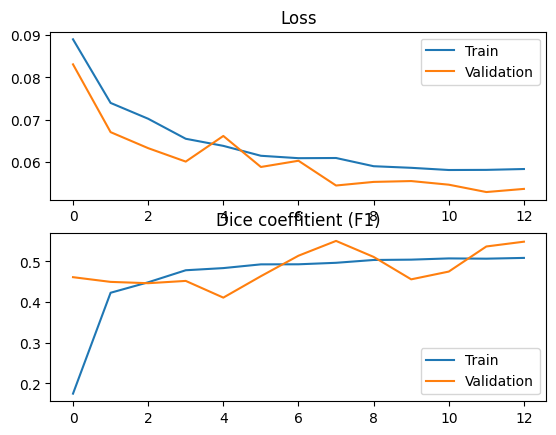

CPU times: user 1h 14min 57s, sys: 17min 39s, total: 1h 32min 37s
Wall time: 56min 46s


In [29]:
%%time
trainer.train(epochs=30, patience=5)
trainer.plot()
# len(train_)

In [31]:
torch.save(model.state_dict(), 'best_model_transfer_transfer_decoder_aug.pth')

In [ ]:
def predict(img, model):
    transformed_img = image_transform(img).to(device)
    transformed_img = transformed_img[None,:,:,:]
    model.eval()
    with torch.no_grad():
        logits = model(transformed_img)
        probs = torch.sigmoid(logits)

        mask = probs > 0.5

    return mask



In [ ]:
def draw_random_predictions(model):
    num_of_images = 3
    img_files = [f for f in os.listdir(image_dir)]
    selected_files = random.sample(img_files, num_of_images)

    fig, axs = plt.subplots(3,3)
    
    for i, file_name in enumerate(selected_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)
        
        image = Image.open(img_path).convert("RGB") 
        
        mask = Image.open(mask_path).convert("L")
        mask = mask_transform(mask)
        
        prediction = predict(image, model)
        axs[i,0].imshow(image)
        
        axs[i,1].imshow(prediction[0,0].cpu(), cmap="gray")

        axs[i,2].imshow(mask[0], cmap="gray")

# Futher training

In [ ]:
best_model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).to(device)

In [ ]:
best_model.load_state_dict(torch.load("/kaggle/input/model_after_training/pytorch/default/1/best_model_transfer_transfer_decoder_aug.pth", weights_only=True))
best_model = best_model.to(device)

In [ ]:
draw_random_predictions(best_model)

In [ ]:
trainer = Trainer(
    model=best_model,
    loss_function=torch.nn.BCEWithLogitsLoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
)

In [ ]:
%%time
trainer.train(epochs=30, patience=5)
trainer.plot()

In [ ]:
draw_random_predictions(best_model)

In [ ]:
draw_random_predictions(best_model)